# **Sentiment Analysis and Clustering of Insurance Industry News Articles Using FinBERT**

## **1. Introduction**



This project aims to leverage BERT, a cutting-edge language model renowned for its advanced Natural Language Processing (NLP) capabilities, to generate embeddings tailored for insurance industry news articles. BERT, short for Bidirectional Encoder Representations from Transformers, represents a pre-trained model developed by Google, engineered to comprehend and contextualise textual data with exceptional precision.

By harnessing BERT's sophisticated deep learning architecture, the project seeks to derive high-quality embeddings specific to insurance news articles. These embeddings function as dense vector representations that encode the semantic essence of the articles, enabling nuanced analysis and interpretation.

The primary objective of this undertaking is to produce embeddings of superior quality that encapsulate the intrinsic meaning and sentiment of insurance industry news. These embeddings will serve as foundational elements for various analytical tasks, initially focusing on sentiment analysis, with potential expansion to accommodate additional tasks in the future.

### **1.1. Project Overview**


The project starts with web scraping to gather insurance industry news from Artemis, followed by data cleaning and exploratory analysis. Then, a sentiment analysis pipeline using BERT models is deployed to extract sentiments and generate article embeddings. Dimensionality reduction and clustering techniques are applied for further analysis, including visualisation. The findings are then summarised, leading to potential future enhancements.

### **1.2. Sentiment Analysis**


Sentiment analysis, particularly in the realm of financial texts, holds considerable value for investors and analysts alike. By employing sophisticated algorithms to analyse textual data, sentiment analysis offers a quantitative means of gauging market sentiment, thereby furnishing stakeholders with a data-driven framework for comprehending market dynamics.

In practical terms, sentiment analysis can offer several notable advantages for stakeholders within the insurance domain. Firstly, it enables the identification and monitoring of prevailing sentiments surrounding various insurance-related topics, such as industry trends, regulatory developments, or emerging risks. This real-time insight into sentiment fluctuations empowers decision-makers to adapt swiftly to evolving market conditions, potentially mitigating risks or capitalising on emerging opportunities.

Moreover, by analysing customer sentiments articulated within news articles, insurers can acquire valuable insights into customer experiences, preferences, and challenges. This informed understanding could enable insurers to customise their offerings and marketing approaches to align more effectively with target demographics, ultimately elevating customer satisfaction and fostering brand loyalty.

Furthermore, sentiment analysis can serve as a potent tool for competitive analysis and benchmarking within the insurance landscape. By comparing sentiment trends across different insurers or industry segments, stakeholders can glean insights into relative market positioning, strengths, and weaknesses. This intelligence can inform strategic decision-making, enabling insurers to refine their competitive strategies and differentiate themselves effectively in the market.

In essence, sentiment analysis offers a multifaceted approach to extracting actionable insights from insurance industry news.

## **2. Set Up and Environment Preparation**

### **2.1. Google Drive Integration**

To facilitate seamless data management and access, the project integrates Google Drive with the Colab environment. This setup allows for efficient storage and retrieval of the dataset and results.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/accelerant'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **2.2. System Configuration Check**

Ensuring the availability of necessary computational resources is crucial for the smooth execution of the project. A check of the system configuration, including GPU availability, is performed to anticipate and mitigate any computational constraints.

In [ ]:
!nvidia-smi

## **3. Data Acquisition**

### **3.1. Source Description**

The dataset comprises insurance industry news articles collected from Artemis, a reputable source known for its extensive coverage of news in the reinsurance, risk transfer, and catastrophe bond markets. This rich dataset serves as the foundation for our sentiment analysis.

### **3.2. Scraping Methodology**

A custom scraping function is developed to extract relevant article content and metadata from Artemis' news pages. Special attention is given to exclude non-relevant links and to manage the scraping pace, ensuring ethical data collection practices are followed.

In [ ]:
import time
from datetime import date
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import re

# Function to extract article URLs from a given page number (max=1389 as of 2024-03-06)
def extract_article_urls(page_number):
    URL = f'https://www.artemis.bm/news/page/{page_number}/'
    source = requests.get(URL).text
    soup = bs(source, 'html.parser')

    articles = soup.find_all('article')
    article_urls = []

    for article in articles:
        article_link = article.find('a')['href']
        # Check if the article link contains the excluded substring
        if "https://www.artemis.bm/news/best-of-artemis-week-ending" not in article_link:
            article_urls.append(article_link)

    return article_urls

# Set the page number of the last scraped URL
last_scraped_page = 0

# Set the number of additional pages to scrape
additional_pages = 1389

# Get the current date
accessed_date = date.today()

# Start scraping from the page following the last scraped page
start_page = last_scraped_page + 1

# Initialise an empty list to store extracted data
article_data = []

# Iterate over the specified number of additional pages to scrape
for page_number in range(start_page, start_page + additional_pages):
    article_urls = extract_article_urls(page_number)

    # Iterate over each article URL and extract data
    for article_url in article_urls:
        source = requests.get(article_url).text
        soup = bs(source, 'html.parser')
        article = soup.find('article')

        # Extract headline
        headline = article.find('h1').text.strip()

        # Extract author and publishing date
        meta_info = article.find('ul', class_='post-meta').text.strip()

        # Using regular expression to separate date and author information
        date_author_match = re.match(r'(.+)(- Author: .+)', meta_info)
        publishing_date = date_author_match.group(1).strip() if date_author_match else None
        author = date_author_match.group(2).replace('- Author: ', '').strip() if date_author_match else None

        # Extract main body excluding the advertisement
        main_body_paragraphs = article.find('div', class_='pf-content').find_all('p')
        main_body = ''
        for p in main_body_paragraphs:
            if "View all of our Artemis Live video interviews" in p.text:
                break
            main_body += p.text + '\n'

        # Extract post tags
        post_tags_section = article.find('p', class_='post-tags')
        post_tags_span = post_tags_section.find('span') if post_tags_section else None
        post_tags = [tag.text.strip() for tag in post_tags_span.find_all('a', rel='tag')] if post_tags_span else []

        # Append extracted data to the list
        article_data.append({
            'Headline': headline,
            'Author': author,
            'Publishing Date': publishing_date,
            'Main Body': main_body.strip(),
            'URL': article_url,
            'Post Tags': post_tags,
            'Accessed Date': accessed_date
        })

        # Introduce delay before making next request
        delay = 1
        time.sleep(delay)

# Create DataFrame from the extracted data
new_df = pd.DataFrame(article_data)

# Read existing data from the Parquet file, if it exists
try:
    existing_df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data.parquet')
except FileNotFoundError:
    existing_df = None

# Concatenate new data with existing data, if it exists
if existing_df is not None:
    combined_df = pd.concat([existing_df, new_df])
else:
    combined_df = new_df

# Save combined DataFrame to Parquet file
combined_df.to_parquet('/content/gdrive/MyDrive/accerlerant/datasets/artemis_data.parquet')

## **4. Data Preprocessing and Cleaning**

### **4.1. Initial Data Inspection**

Upon acquiring the data, an initial inspection is conducted to identify any glaring issues such as missing values, duplicate entries, or irrelevant data points. This step is critical for determining the scope of preprocessing needed.

In [ ]:
!pip install pyarrow
import pandas as pd

# Read the Parquet file into a DataFrame
existing_df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data.parquet')

# Display information about the DataFrame
existing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790 entries, 0 to 18789
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Headline         18790 non-null  object
 1   Author           18790 non-null  object
 2   Publishing Date  18790 non-null  object
 3   Main Body        18790 non-null  object
 4   URL              18790 non-null  object
 5   Post Tags        18790 non-null  object
 6   Accessed Date    18790 non-null  object
dtypes: object(7)
memory usage: 1.0+ MB


In [ ]:
# Display the head of the DataFrame
existing_df.head()

,Headline,Author,Publishing Date,Main Body,URL,Post Tags,Accessed Date
0,"2023 reinsurance “step change” broadly held, n...",Steve Evans,6th March 2024,The “step change” in property catastrophe rein...,https://www.artemis.bm/news/2023-reinsurance-s...,"[reinsurance, Reinsurance renewals news]",2024-03-06
1,Everest’s Mt. Logan Re makes two senior invest...,Steve Evans,6th March 2024,"Mt. Logan Re Ltd., the Everest Group owned and...",https://www.artemis.bm/news/everests-mt-logan-...,"[Collateralized reinsurance, Everest Re, ILS f...",2024-03-06
2,SCOR benefits from positive hurricane Ian loss...,Steve Evans,6th March 2024,SCOR has reported a significant -7.2 point ben...,https://www.artemis.bm/news/reinsurance-news/s...,"[Hurricane Ian 2022, reinsurance, Retrocession]",2024-03-06
3,Jamaica targets four hurricane season catastro...,Steve Evans,6th March 2024,Jamaica is looking to renew its catastrophe bo...,https://www.artemis.bm/news/jamaica-targets-fo...,"[Cat bond, Catastrophe bond, Insurance linked ...",2024-03-06
4,"Gateway Re 2024-1 cat bond target increased, a...",Steve Evans,6th March 2024,The target size for the Gateway Re Ltd. (Serie...,https://www.artemis.bm/news/gateway-re-2024-1-...,"[Cat bond, Catastrophe bond, Gateway Re Ltd, G...",2024-03-06


### **4.2. Duplicate Removal**

Identifying and removing duplicates is paramount to maintain the integrity of the analysis.

Duplicate headlines were checked and displayed if found. Duplicate rows based on the 'Headline' column were dropped, and the index was reset.

In [ ]:
import pandas as pd

# Read the Parquet file into a DataFrame
existing_df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data.parquet')

# Check for duplicate headlines
duplicate_headlines = existing_df[existing_df.duplicated(subset='Headline', keep=False)]

# Display the duplicate headlines
print("Duplicate Headlines:")
print(duplicate_headlines['Headline'])

# Drop duplicate rows based on the Headline column
deduplicated_df = existing_df.drop_duplicates(subset='Headline').copy()  # Make a copy to avoid SettingWithCopyWarning

# Reset the index after dropping duplicates
deduplicated_df.reset_index(drop=True, inplace=True)

# Save the DataFrame with duplicates removed to a new Parquet file
intermediate_file = '/content/gdrive/MyDrive/accelerant/datasets/artemis_data_deduplicated.parquet'
deduplicated_df.to_parquet(intermediate_file)

Duplicate Headlines:
203      Insured catastrophe losses reach $118bn in 202...
204      Insured catastrophe losses reach $118bn in 202...
3860     Philippines gets $500m World Bank catastrophe ...
7543     Typhoon Hagibis forecast to impact Tokyo regio...
7561     Typhoon Hagibis forecast to impact Tokyo regio...
7567     Typhoon Hagibis forecast to impact Tokyo regio...
12389    Another billion dollar week of U.S. severe wea...
12465    Another billion dollar week of U.S. severe wea...
12792    Philippines gets $500m World Bank catastrophe ...
Name: Headline, dtype: object


### **4.3. Date Formatting**

 Ordinal indicators were removed from the 'Publishing Date' column, which was then converted to datetime format. After conversion, 'NaT' values in the 'Publishing Date' column were counted, and rows with 'NaT' values were filtered out, with unique failed conversion values displayed. The modified DataFrame was saved to a new file for further analysis.

In [ ]:
import pandas as pd

# Load the intermediate DataFrame
deduplicated_df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_deduplicated.parquet')

# Remove the ordinal indicators from the 'Publishing Date' column
deduplicated_df.loc[:, 'Publishing Date'] = deduplicated_df['Publishing Date'].str.replace(r'(\d+)(st|nd|rd|th)', r'\1', regex=True)

# Convert the 'Publishing Date' column to datetime format
deduplicated_df.loc[:, 'Publishing Date'] = pd.to_datetime(deduplicated_df['Publishing Date'], errors='coerce')

# Count the number of 'NaT' values in the 'Publishing Date' column after conversion
num_nat_values = deduplicated_df['Publishing Date'].isna().sum()
print("Number of 'NaT' values after conversion:", num_nat_values)

# Filter out rows with 'NaT' values and display unique values in 'Publishing Date' column
failed_conversion_rows = deduplicated_df[deduplicated_df['Publishing Date'].isna()]
unique_failed_values = failed_conversion_rows['Publishing Date'].unique()
print("\nUnique values in 'Publishing Date' column that failed to convert:")
for value in unique_failed_values:
    print(value)

# Convert 'Publishing Date' column to string format
deduplicated_df['Publishing Date'] = deduplicated_df['Publishing Date'].astype(str)

# Save the modified DataFrame to the new Parquet file
deduplicated_df.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

<ipython-input-5-4931829d2a7f>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  deduplicated_df.loc[:, 'Publishing Date'] = pd.to_datetime(deduplicated_df['Publishing Date'], errors='coerce')


Number of 'NaT' values after conversion: 0

Unique values in 'Publishing Date' column that failed to convert:


In [ ]:
import pandas as pd

# Load DataFrame
df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

# Get the shape of the DataFrame
dataset_size = df.shape

# Print the size of the dataset
print("Size of the dataset:", dataset_size)

Size of the dataset: (18785, 7)


In [ ]:
df.head()

,Headline,Author,Publishing Date,Main Body,URL,Post Tags,Accessed Date
0,"2023 reinsurance “step change” broadly held, n...",Steve Evans,2024-03-06,The “step change” in property catastrophe rein...,https://www.artemis.bm/news/2023-reinsurance-s...,"[reinsurance, Reinsurance renewals news]",2024-03-06
1,Everest’s Mt. Logan Re makes two senior invest...,Steve Evans,2024-03-06,"Mt. Logan Re Ltd., the Everest Group owned and...",https://www.artemis.bm/news/everests-mt-logan-...,"[Collateralized reinsurance, Everest Re, ILS f...",2024-03-06
2,SCOR benefits from positive hurricane Ian loss...,Steve Evans,2024-03-06,SCOR has reported a significant -7.2 point ben...,https://www.artemis.bm/news/reinsurance-news/s...,"[Hurricane Ian 2022, reinsurance, Retrocession]",2024-03-06
3,Jamaica targets four hurricane season catastro...,Steve Evans,2024-03-06,Jamaica is looking to renew its catastrophe bo...,https://www.artemis.bm/news/jamaica-targets-fo...,"[Cat bond, Catastrophe bond, Insurance linked ...",2024-03-06
4,"Gateway Re 2024-1 cat bond target increased, a...",Steve Evans,2024-03-06,The target size for the Gateway Re Ltd. (Serie...,https://www.artemis.bm/news/gateway-re-2024-1-...,"[Cat bond, Catastrophe bond, Gateway Re Ltd, G...",2024-03-06


## **5. Time Series Analysis (TSA)**

### **5.1. Temporal Dynamics of Content Volume**

This analysis will provide a comprehensive overview of the publication trends, helping to understand the dataset's range and the consistency of content production. It forms the basis for assessing data completeness and informing decisions on temporal aspects of modelling and strategy development.

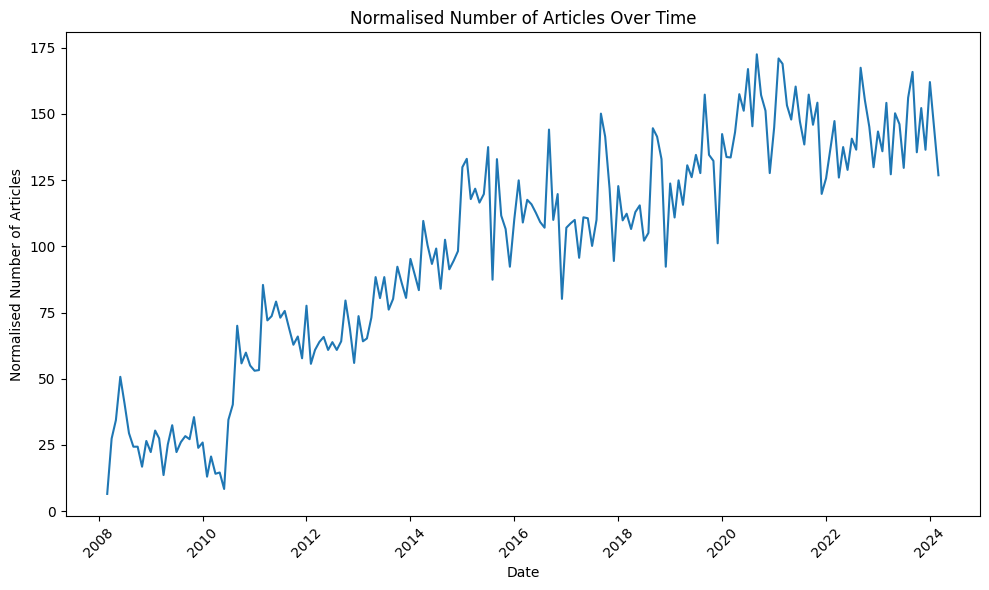



The dataset spans from 2008-03-21 to 2024-03-06


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed DataFrame
df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

# Convert 'Publishing Date' to datetime
df['Publishing Date'] = pd.to_datetime(df['Publishing Date'])

# Dataset time range
oldest_article_date = df['Publishing Date'].min()
newest_article_date = df['Publishing Date'].max()

# Format the dates to exclude the time
formatted_oldest_date = oldest_article_date.strftime('%Y-%m-%d')
formatted_newest_date = newest_article_date.strftime('%Y-%m-%d')

# Creating a new DataFrame for time series analysis
time_series_df = df.groupby(df['Publishing Date'].dt.to_period("M")).size().reset_index(name='Counts')

# Convert 'Publishing Date' back to datetime for plotting
time_series_df['Publishing Date'] = time_series_df['Publishing Date'].dt.to_timestamp()

# Calculate the number of days covered for each month
df['YearMonth'] = df['Publishing Date'].dt.to_period('M')
df['Day'] = df['Publishing Date'].dt.day
days_per_month = df.groupby('YearMonth')['Day'].max().reset_index()

# Calculate the total counts per month and normalise by days covered
article_counts = df.groupby('YearMonth').size().reset_index(name='Counts')
normalised_df = pd.merge(article_counts, days_per_month, on='YearMonth')
normalised_df['Normalised Counts'] = (normalised_df['Counts'] / normalised_df['Day']) * 30.44

# Convert 'YearMonth' from period to timestamp for plotting
normalised_df['YearMonth'] = normalised_df['YearMonth'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(10,6))
sns.lineplot(data=normalised_df, x='YearMonth', y='Normalised Counts')
plt.title('Normalised Number of Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Normalised Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n")
print(f"The dataset spans from {formatted_oldest_date} to {formatted_newest_date}")

The graph above shows a time series analysis of article publication counts, normalised and aggregated on a monthly basis from March 2008 to March 2024. There is a clear upward trend in publication volume over the years, with seasonal fluctuations. Such a pattern suggests that further time series analysis could enhance the comprehension of discourse patterns within the insurance industry, thereby informing strategic decision-making processes.



### **5.2. Application to Future Analysis of Dataset**

Time series analysis through NLP could provide valuable insights, enabling the tracking and forecasting of key trends, sentiment shifts, and topic developments in insurance industry-related discussions. These methods can also detect anomalies and correlate industry discourse with external events, offering a comprehensive toolkit for data-driven strategic planning and risk management.

Applicable NLP methods for time series analysis include:



1.   Trend Detection
2.   Event Correlation
3.   Topic Modeling
4.   Anomaly Detection
5.   Predictive Analytics
6.   Sentiment Analysis









### **5.3. Application to Current Project**


The current project aims to leverage BERT class models for sentiment analysis on insurance industry news articles. The potential value of incorporating time series analysis into the pipeline is recognised. This addition could involve preprocessing the text data to extract sentiment features over time, then feeding this data into the model for analysis.

Due to current time constraints, the integration of time series analysis into the sentiment analysis pipeline will not be immediately pursued. However, incorporating this approach presents an opportunity for future enhancements which would augment the capability of the model to describe temporal changes in sentiment within the insurance sector. This inclusion would allow for the dynamic tracking of sentiment trends over time, improving the predictive accuracy of the model and enabling more nuanced, timely responses to emerging sentiments and trends in the market.

## **6. Exploratory Data Analysis (EDA) on Authorship and Article Tags**

This EDA serves as a crucial initial step in comprehensively understanding the dataset. By exploring the distribution of author contributions and the prevalence of different article tags, a deeper understanding of the dataset's structure is attained, guiding subsequent analytical approaches and potential feature engineering strategies.

### **6.1. Authorship Distribution Across Articles**

To understand the distribution of content creation among different contributors and assess the potential for author-based features in subsequent analysis, the
distribution of article authorship is examined. This will clarify whether sufficient diversity in authorship exists to inform content strategies and feature engineering.

Artemis                      10164
Steve Evans                   8181
Luke Gallin                    377
Matt Sheehan                    23
Artemis Team                    20
Kane Wells                       7
Katie Baker                      6
Kassandra Jimenez-Sanchez        4
Akankshita Mukhopadhyay          2
Jack Willard                     1
Name: Author, dtype: int64


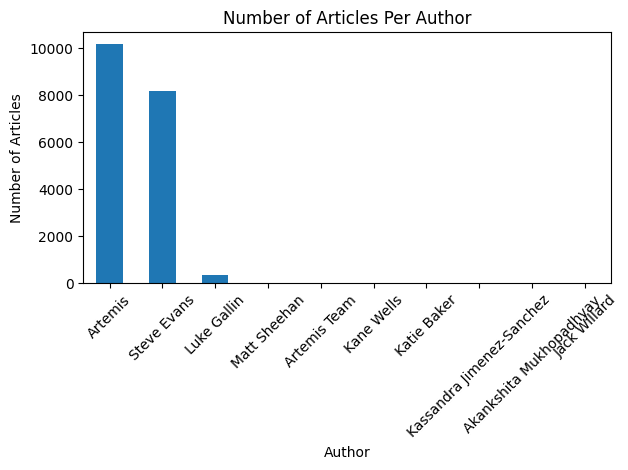

In [ ]:
# Load the Parquet file into a DataFrame
df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

# Articles Per Author
articles_per_author = df['Author'].value_counts()
print(articles_per_author)

# Bar plot
articles_per_author.plot(kind='bar')
plt.title('Number of Articles Per Author')
plt.xlabel('Author')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph shows a heavily skewed distribution of articles per author, with 'Steve Evans' and 'Artemis' (presumably a collective of authors) dominating the output. The lack of author diversity suggests limited value in using authorship as a feature for analysis, as the dataset does not offer a broad representation of individual author contributions.

### **6.2. Article Tag Distribution**

An exploratory analysis of article tags provides insights into common themes and subjects covered in the dataset. Understanding tag distribution aids in categorising articles and can guide the sentiment analysis process.

A histogram and an empirical cumulative distribution function (ECDF) of tag counts per article were plotted to inform the appropriate number of tags for fixed-length representation. These visualisations provided insights into the distribution and frequency of tags across articles, aiding in determining an optimal fixed size for tag vectors. Fixed-length representations are essential for consistent input dimensions in machine learning models, especially when dealing with varied data. The aim is to select a fixed length that accommodates the majority of articles whilst minimising information loss for those with tag counts exceeding this length. This approach ensures that the input to the model remains uniform, facilitating more efficient training and potentially enhancing model performance by focusing on the most pertinent tags within a predetermined constraint.

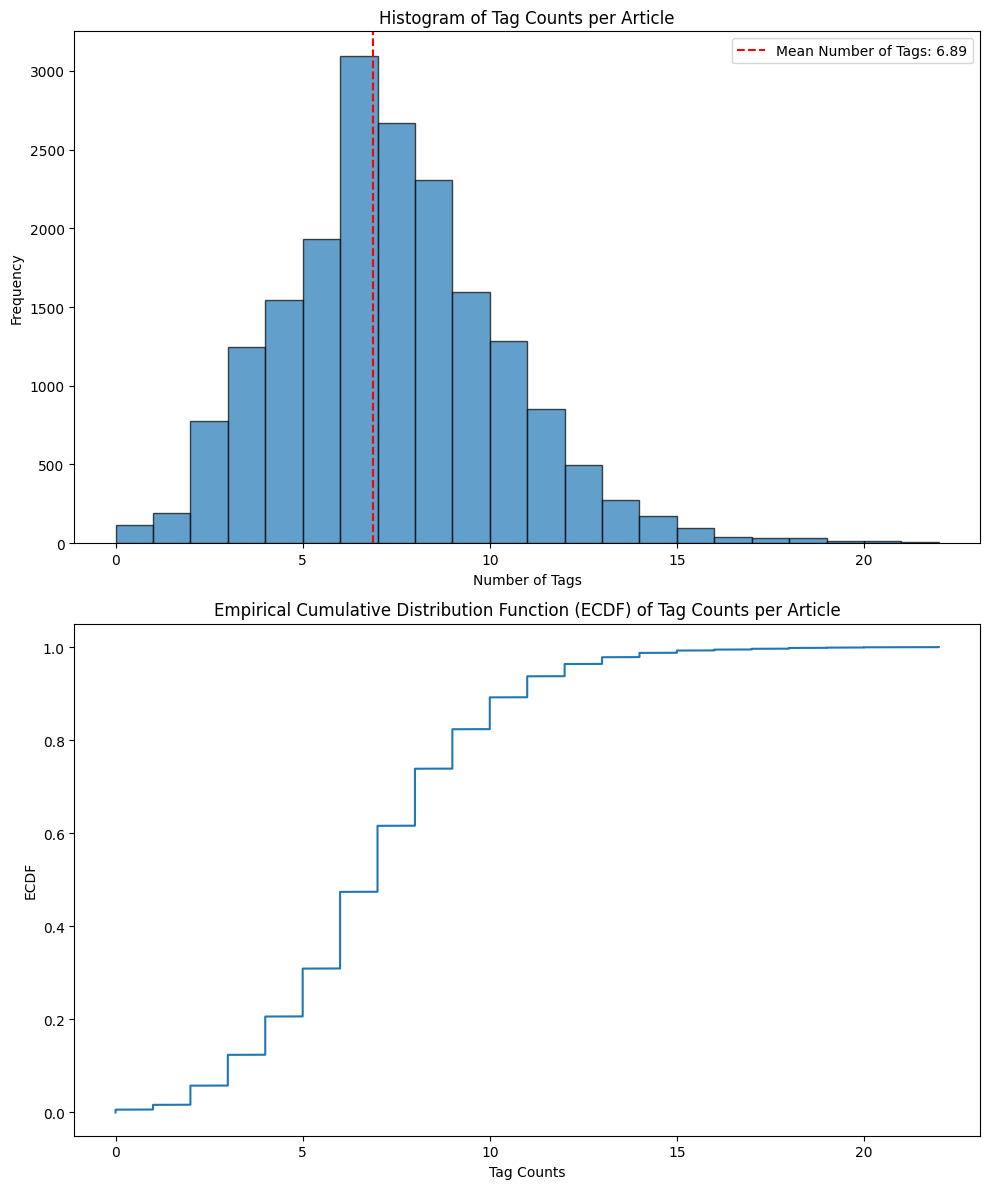

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

# Load the Parquet file into a DataFrame
df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

# Extract tags
tags = df['Post Tags']

# Compute tag counts
tag_counts = [len(tag_list) for tag_list in tags]

# Convert tag_counts to a numpy array of floats
tag_counts = np.array(tag_counts, dtype=float)

# Replace infinite values with NaN
tag_counts[np.isinf(tag_counts)] = np.nan

# Compute mean number of tags
mean_tag_count = np.nanmean(tag_counts)

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot Histogram of Tag Counts per Article
axes[0].hist(tag_counts[~np.isnan(tag_counts)], bins=range(int(np.nanmin(tag_counts)), int(np.nanmax(tag_counts)) + 1), edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram of Tag Counts per Article')
axes[0].set_xlabel('Number of Tags')
axes[0].set_ylabel('Frequency')
axes[0].axvline(x=mean_tag_count, color='red', linestyle='--', label=f'Mean Number of Tags: {mean_tag_count:.2f}')
axes[0].legend()

# Plot ECDF of Tag Counts per Article
ecdf = ECDF(tag_counts[~np.isnan(tag_counts)])
axes[1].plot(ecdf.x, ecdf.y)
axes[1].set_title('Empirical Cumulative Distribution Function (ECDF) of Tag Counts per Article')
axes[1].set_xlabel('Tag Counts')
axes[1].set_ylabel('ECDF')

# Add space between subplots
plt.tight_layout()

# Show the plots
plt.show()

### **6.3. Analysis of Article Tag Frequency**

The prominence of topics in the dataset is quantified by assessing tag frequencies. A tally of occurrences for each tag uncovers the dominant themes, with the 50 most frequent tags providing insights into the primary subjects of the financial news articles. The total number of unique tags reflects the diversity of content covered.

In [ ]:
import pandas as pd

# Load the Parquet file into a DataFrame
df = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')

# Extract all tags
all_tags = [tag for tags_list in df['Post Tags'] for tag in tags_list]

# Calculate tag frequency
tag_frequency = {}
for tag in all_tags:
    tag_frequency[tag] = tag_frequency.get(tag, 0) + 1

# Sort tags by frequency
sorted_tags = sorted(tag_frequency.items(), key=lambda x: x[1], reverse=True)

# Create DataFrame from sorted tags
tags_df = pd.DataFrame(sorted_tags[:50], columns=['Tag', 'Frequency'])

# Total number of unique tags
total_unique_tags = len(tag_frequency)

# Display the top 50 tags and their frequencies along with the total number of unique tags
print("Top 50 Tags and their Frequencies:")
print(tags_df)
print("\nTotal number of unique tags:", total_unique_tags)

Top 50 Tags and their Frequencies:
                                                  Tag  Frequency
0                                         reinsurance      14116
1                         Insurance linked securities      11408
2                                    Catastrophe bond       8486
3                                            Cat bond       7997
4                                           ILS funds       6320
5                                           insurance       5086
6                                     capital markets       4828
7                     Alternative reinsurance capital       4008
8                          Collateralized reinsurance       3932
9                     third-party reinsurance capital       3920
10                       Insurance-linked investments       3530
11                      Reinsurance linked investment       3368
12                                       Retrocession       2025
13                          Reinsurance renewals news  

The dataset displays a significant diversity of article tags, indicated by the abundance of unique tags. While this suggests a broad spectrum of topics covered within insurance industry news articles, it also reveals a pattern of tag similarity. For instance, tags such as "Catastrophe bond," "Cat bond," "Cat bond fund," "Private cat bond," and "Catastrophe bond fund" all pertain to similar concepts but are listed separately, contributing to redundancy. Similarly, tags like "Coronavirus news" and "Covid-19 news" represent the same topic but are treated as distinct tags, highlighting the need for tag consolidation and standardisation in the dataset preprocessing phase.

### **6.4. Article Labelling Issues**

Article Tag data was collected with the intention of deriving labels for the articles for use in sequence classification using BERT. However, the EDA, and subsequent analysis revealed several challenges; including the large number of unique tags, tag similarity, and truncation bias issues.

In an attempt to overcome these obstacles, several preprocessing steps were implemented to refine the tag data for better utility. Initially, lemmatization was applied to reduce words to their base or dictionary form, to consolidate variations of the same word. Following this, stemming was implemented to trim words down to their root forms, to further reduce the complexity and variability of the tag set.

Despite these efforts, the diversity and inconsistency of the tag data persisted, necessitating more sophisticated methods. Automated clustering techniques to group similar tags, were explored with the aim of reducing the overall tag count and addressing the issue of tag similarity. However, the nuanced and context-specific nature of the tags, coupled with the limitations of unsupervised methods in capturing these subtleties, led to partial success.

Ultimately, it became evident that to achieve a level of accuracy conducive to training a high-performing BERT model, a certain degree of manual labelling would be required.

### **6.5. Adjusting Pipeline for Unlabelled Data**

Considering time constraints and the challenges associated with labeling articles using tags, it was decided that the project would use unlabelled data for sentiment analysis. This decision precludes the fine-tuning of the BERT-base-cased model and necessitates the use of unsupervised learning methods. As a result, an alternative model, pre-trained in the finance domain, was selected. However, when the labeling issue can be resolved, the project can explore the possibility of using a BERT model and pretraining it on the dataset, providing additional flexibility and potentially enhancing the model's performance.

## **7. Sentiment Analysis Pipeline**

### **7.1. Introduction to BERT Models and Their Application in Sentiment Analysis**

Bidirectional Encoder Representations from Transformers, or BERT models, represent the forefront in Natural Language Processing (NLP), providing a sophisticated framework that captures the full context of words within text. Unlike prior models, BERT captures bidirectional context, resulting in embeddings that offer a deeper semantic understanding of language. These embeddings are multi-dimensional representations that enable machine learning algorithms to process text data effectively.

### **7.2. Model Selection: FinBERT**

FinBERT, a specialised adaptation of the generic BERT model, is specifically pre-trained on a large corpus of financial text to accurately capture the subtleties of financial text. The model's nuanced approach to text analysis promises a more precise interpretation of market sentiment, offering valuable insights for decision-making processes. By leveraging FinBERT, this project aims to distill high-quality article embeddings, forming the backbone of a comprehensive sentiment analysis.

### **7.3.a. Data Splitting**

In this preprocessing step, the Artemis news dataset is divided into subsets for training, validation, testing, fine-tuning, and inference. The purpose is to prepare the data for subsequent machine learning tasks. The split ratios are chosen to balance the need for training, validation, and testing data, aiming to provide sufficient data for model training and evaluation while avoiding overfitting. Moreover, the allocation ensures that ample samples are available for fine-tuning the model and conducting inference, enabling comprehensive analysis and refinement of the model's performance.

Note: This stage was not implemented due to the use of unlabelled data at this time, rendering pre-training/fine-tuning unnecessary.
Therefore, the inference dataset used in the pipeline uses 100% of the data collected (18785 articles)

In [ ]:
"""
import pandas as pd
import numpy as np

# Load the data
artemis_news_dataset = '/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet'
data = pd.read_parquet(artemis_news_dataset)

# Define proportions for different datasets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.1
fine_tune_ratio = 0.1
inference_ratio = 0.1

# Calculate the number of samples for each set
num_samples = len(data)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_fine_tune = int(fine_tune_ratio * num_samples)
num_inference = int(inference_ratio * num_samples)

# Shuffle the indices
indices = np.random.permutation(num_samples)

# Calculate the indices for each set
train_indices = indices[:num_train]

# Remove train_indices from the remaining indices
remaining_indices = np.delete(indices, np.arange(num_train))

# Shuffle the remaining indices
np.random.shuffle(remaining_indices)

# Calculate val_indices
val_indices = remaining_indices[:num_val]

# Remove val_indices from the remaining indices
remaining_indices = np.delete(remaining_indices, np.arange(num_val))

# Shuffle the remaining indices
np.random.shuffle(remaining_indices)

# Calculate fine_tune_indices
fine_tune_indices = remaining_indices[:num_fine_tune]

# Remove fine_tune_indices from the remaining indices
remaining_indices = np.delete(remaining_indices, np.arange(num_fine_tune))

# Shuffle the remaining indices
np.random.shuffle(remaining_indices)

# Calculate test_indices
test_indices = remaining_indices[:num_test]

# Remove test_indices from the remaining indices
remaining_indices = np.delete(remaining_indices, np.arange(num_test))

# Shuffle the remaining indices
np.random.shuffle(remaining_indices)

# Calculate inference_indices
inference_indices = remaining_indices[:num_inference]

# Split the data based on the indices
train_data = data.iloc[train_indices]
val_data = data.iloc[val_indices]
fine_tune_data = data.iloc[fine_tune_indices]
test_data = data.iloc[test_indices]
inference_data = data.iloc[inference_indices]

# Save the split datasets
train_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/train_data.parquet')
val_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/val_data.parquet')
fine_tune_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/fine_tune_data.parquet')
test_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/test_data.parquet')
inference_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/inference_data.parquet')
"""

In [ ]:
import pandas as pd

# Load the preprocessed DataFrame
inference_data = pd.read_parquet('/content/gdrive/MyDrive/accelerant/datasets/artemis_data_preprocessed.parquet')


# Save the loaded DataFrame as 'inference_data.parquet'
inference_data.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/inference_data.parquet')

### **7.3. Adapting to BERT's Input Constraints: Tokenization and Automated Chunking**

Tokenization is an integral step in preparing text for analysis with BERT models, including FinBERT. It transforms raw text into a sequence of tokens that the model can interpret. Given the inherent input size limit of FinBERT, the processing of extensive articles requires an alternative approach beyond standard tokenization.

In response to this challenge, the code implements an automated chunking method for articles that exceed FinBERT’s maximum token limit. After tokenization, if an article's token count surpasses the threshold, it is automatically segmented into smaller portions or "chunks". These chunks are systematically determined based on a predefined maximum chunk length, ensuring each segment falls within FinBERT's processing capabilities.

This chunking method is essential for analysing longer texts comprehensively. By dividing articles into manageable pieces, the entire content is considered without manual selection or arbitrary exclusion of text segments. Each chunk is independently processed, allowing the model to capture and analyse the full narrative content of even the most extensive articles. This approach ensures that the analysis remains thorough and inclusive, vital for extracting nuanced sentiment insights.

Note: Dataset loaded in the following block is named 'inference_data' to make passive provision for future data splitting. Training, validation, testing, and inference datasets will be required to implement fine-tuning and training steps for the'BERT-base-cased' model once article labelling is resolved.

In [ ]:
# Necessary imports for data manipulation, neural network architecture, and NLP processing
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Path to the dataset stored on Google Drive
inference_dataset = '/content/gdrive/MyDrive/accelerant/datasets/inference_data.parquet'

# Initialising the tokenizer and model from Hugging Face's Transformers library
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Loading the dataset into a pandas DataFrame
inference_data_df = pd.read_parquet(inference_dataset)

# Function to tokenize and chunk articles into segments within FinBERT's input size limit
def tokenize_and_chunk(text, tokenizer, max_chunk_length=510, max_length=512):
    # Tokenize the text with padding and truncation to fit the model's maximum input size
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Calculate the number of chunks needed for each article based on the token count
    total_length = input_ids.size(1)
    chunks = [(input_ids[:, i:i+max_chunk_length], attention_mask[:, i:i+max_chunk_length]) for i in range(0, total_length, max_chunk_length)]
    return chunks

# Initialise lists to store processed data
all_embeddings = []
all_labels = []

# Loop through each article, tokenize, and chunk it for processing
for article in inference_data_df['Main Body']:
    chunks = tokenize_and_chunk(article, tokenizer)

### **7.4. Sentiment Label and Article Embeddings Generation**

The FinBERT model processes article segments to assign sentiment labels and generate embeddings, directly transforming text into quantifiable sentiment insights and semantic representations. This dual output provides a comprehensive view of each article’s sentiment and is central to analysing financial news trends and patterns.

In [ ]:
# Function to calculate embeddings and sentiment labels for each chunk of an article
def calculate_embeddings_and_labels(chunks, model):
    embeddings = []
    labels = []
    # Disabling gradient calculation for inference mode
    with torch.no_grad():
        for input_ids, attention_mask in chunks:
            # Processing each chunk through FinBERT
            output = model(input_ids=input_ids.to(model.device), attention_mask=attention_mask.to(model.device))
            logits = output.logits
            # Applying softmax to logits to get probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # Storing probabilities (embeddings) and predicted labels for each chunk
            embeddings.append(probs.cpu().numpy())
            labels.append(probs.argmax(dim=-1).cpu().numpy())
    return embeddings, labels

# Continuing from the previous loop to process each chunk through the model
for article in inference_data_df['Main Body']:
    # 'chunks' as defined in the previous code block
    embeddings, labels = calculate_embeddings_and_labels(chunks, model)
    # Averaging embeddings across chunks and determining the most frequent sentiment label
    article_embeddings = np.mean(np.concatenate(embeddings, axis=0), axis=0)
    most_frequent_label = np.bincount(np.concatenate(labels)).argmax()
    # Appending processed data for all articles
    all_embeddings.append(article_embeddings)
    all_labels.append(most_frequent_label)

# Applying PCA to reduce the dimensionality of the embeddings for visualisation and further analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)

# Updating the DataFrame with new columns for BERT embeddings, sentiment labels, and PCA components
inference_data_df['BERT_Embeddings'] = list(all_embeddings)
inference_data_df['Sentiment_Label'] = all_labels
inference_data_df['PCA_Component_1'] = pca_embeddings[:, 0]
inference_data_df['PCA_Component_2'] = pca_embeddings[:, 1]
inference_data_df['PCA_Component_3'] = pca_embeddings[:, 2]

# Saving the updated DataFrame with additional insights back to a Parquet file for persistence
inference_data_df.to_parquet('/content/gdrive/MyDrive/accelerant/datasets/inference_data_with_embeddings_sentiment_pca.parquet')


## **8. Dimensionality Reduction**

Dimensionality reduction, particularly through Principal Component Analysis (PCA), plays a pivotal role in embedding analysis by distilling complex, high-dimensional data into more interpretable forms. This process simplifies the embeddings derived from FinBERT, focusing on the most significant patterns of variance among the articles. By reducing the dimensions, PCA facilitates a clearer visualisation and understanding of how the Artemis articles cluster in terms of sentiment and content. This step not only aids in visual explorations but also enhances computational efficiency and sharpens the focus for subsequent clustering algorithms, making it easier to identify meaningful insights within the data.

### **8.1. Visualising Reduced Dimensions: PCA Scatter Plot**

The scatter plot of the first two principal components from PCA highlights the dataset's key structural patterns. This visualisation simplifies the embeddings into two dimensions, revealing potential clusters and thematic relationships among articles. It offers a clear, concise view of the data's variance, setting the stage for deeper clustering analysis.

Text(0, 0.5, 'Principal Component 2')

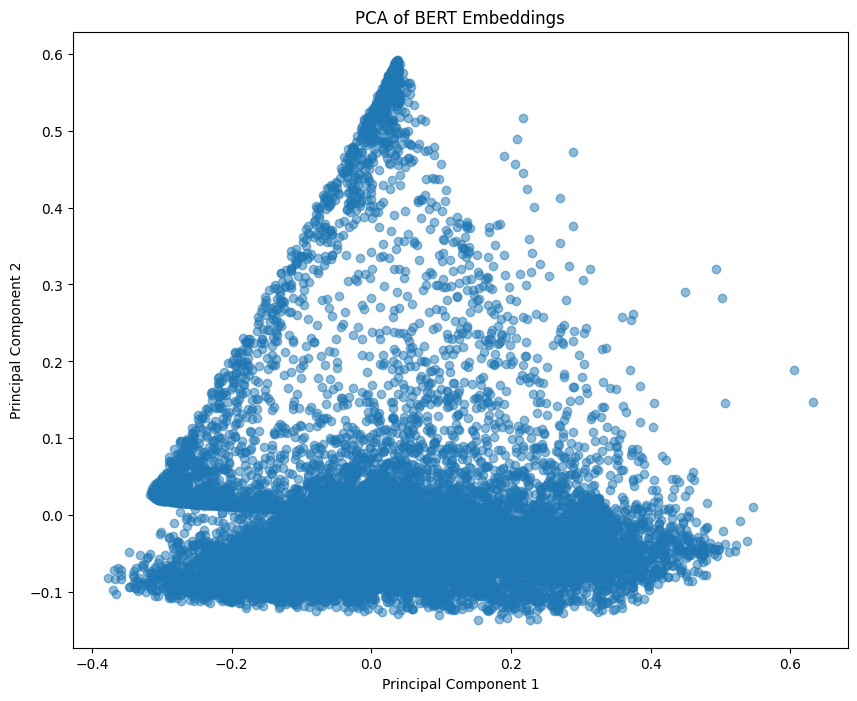

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load data
parquet_file = '/content/gdrive/MyDrive/accelerant/datasets/inference_data_with_embeddings_sentiment_pca.parquet'
data = pd.read_parquet(parquet_file)

# Extract the first two PCA components
pca_components = data[['PCA_Component_1', 'PCA_Component_2']].values

# Plot the first two principal components as an xy scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.5)
plt.title('PCA of BERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## **9. Clustering**

Following dimensionality reduction, K-means clustering is employed to categorise the articles by their embeddings, aiming to isolate patterns or sentiments. This method elucidates the data's structure, facilitating an exploration of prevalent themes.

### **9.1. Clustering Visualisation (2D)**

The 2D scatter plot of PCA-transformed embeddings, coupled with K-means clustering, highlights the dataset's primary structural variations. Colors differentiate clusters, and center markers emphasise their cores, offering a clear view of thematic groupings in two principal dimensions.

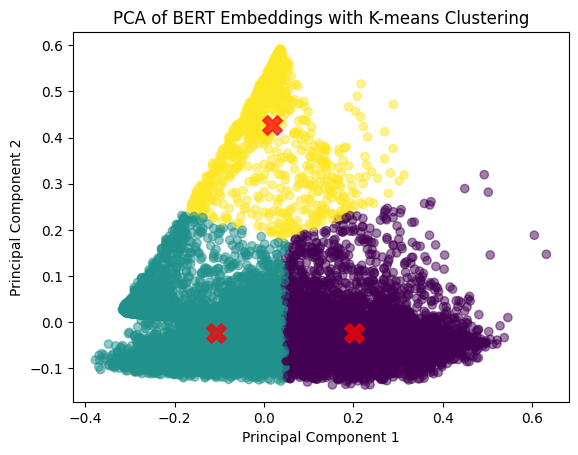

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load DataFrame PCA components and cluster labels
parquet_file = '/content/gdrive/MyDrive/accelerant/datasets/inference_data_with_embeddings_sentiment_pca.parquet'
data = pd.read_parquet(parquet_file)

# Extract the first two PCA components for 2D plotting
pca_components = data[['PCA_Component_1', 'PCA_Component_2']].values

# Perform K-means clustering on the PCA results
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit(pca_components)
cluster_labels = kmeans.labels_

# Plot the clustered data
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('PCA of BERT Embeddings with K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### **9.2. Clustering Visualisation (3D)**

The shift to a 3D scatter plot introduces an extra dimension, enriching the analysis of PCA-transformed embeddings. This approach enables a more detailed exploration of how articles cluster in embedding space.

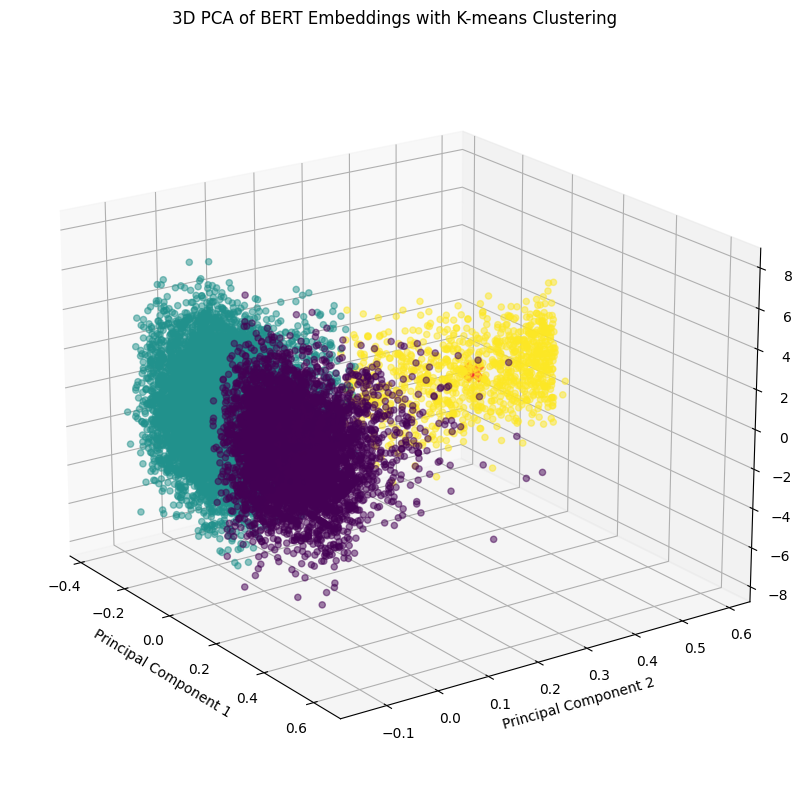

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is needed for 3D plotting
from sklearn.cluster import KMeans

# Load DataFrame PCA components and cluster labels
parquet_file = '/content/gdrive/MyDrive/accelerant/datasets/inference_data_with_embeddings_sentiment_pca.parquet'
data = pd.read_parquet(parquet_file)

# Extract the first three PCA components
pca_components = data[['PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3']].values

# Perform K-means clustering on the PCA results
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42).fit(pca_components)
data['Cluster_Labels'] = kmeans.labels_  # Add the cluster labels to the DataFrame

# Save the updated DataFrame with cluster labels to the Parquet file
data.to_parquet(parquet_file)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-35)

# Scatter plot for the PCA components with clustering
ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c=data['Cluster_Labels'], cmap='viridis', alpha=0.5)

# Marking cluster centers
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.75, marker='X')

ax.set_title('3D PCA of BERT Embeddings with K-means Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3', labelpad=20)
plt.show()

## **10. Visualising Sentiment Distribution in Embedding Space**

Following the generation of sentiment labels and article embeddings, a visualisation is constructed to explore the sentiment distribution across the embedding space derived from PCA components. This visualisation employs a 3D scatter plot to map articles based on their PCA-transformed embeddings, with colors indicating the sentiment classification—ranging from negative to positive.

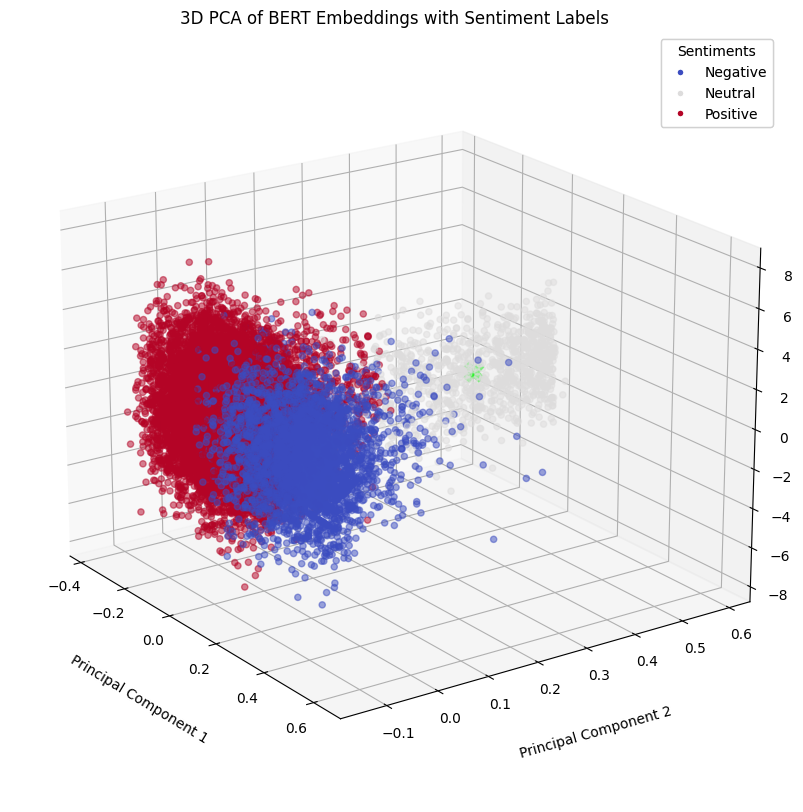

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Load Data
parquet_file = '/content/gdrive/MyDrive/accelerant/datasets/inference_data_with_embeddings_sentiment_pca.parquet'
inference_data_df = pd.read_parquet(parquet_file)

# Extract the first three PCA components and sentiment labels
pca_components = inference_data_df[['PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3']].values
sentiment_labels = inference_data_df['Sentiment_Label'].values

# Label sentiments
sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-35)

# Scatter plot for the PCA components with sentiment as color
scatter = ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2],
                     c=sentiment_labels, cmap='coolwarm', alpha=0.5)

# Create a legend for sentiments
sentiment_labels_unique = np.unique(sentiment_labels)
custom_legends = [plt.Line2D([0], [0], marker='o', color='w', label=sentiment_map[label],
                             markerfacecolor=plt.cm.coolwarm(label / max(sentiment_labels_unique)), markersize=5)
                  for label in sentiment_labels_unique]

legend1 = ax.legend(handles=custom_legends, title="Sentiments", loc='upper right')
ax.add_artist(legend1)

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='lime', s=200, alpha=0.75, marker='X')

ax.set_title('3D PCA of BERT Embeddings with Sentiment Labels')
ax.set_xlabel('Principal Component 1', labelpad=20)
ax.set_ylabel('Principal Component 2', labelpad=20)
ax.set_zlabel('Principal Component 3', labelpad=20)

plt.show()


## **11. Insights and Implications**

In the preliminary analysis, Principal Component Analysis (PCA) was applied to reduce the dimensionality of BERT embeddings derived from the dataset. This technique facilitated the visualisation of complex, high-dimensional data in a three-dimensional space. K-means clustering was utilised to identify natural groupings within the data, revealing clusters that suggest thematic or semantic coherence among the articles. These clusters became evident in the PCA-reduced space, indicating that articles within the same cluster have similar BERT embeddings, suggesting potential content or contextual similarities.

The analysis was further extended by assigning sentiment scores to the data points—categorised as negative, neutral, and positive. This sentiment labeling provided a depiction of the emotional tone distribution within the PCA-reduced BERT embedding space. While the clustering highlighted the semantic structure, the sentiment labels offered an interpretive layer regarding the articles' sentiment. The sentiment visualisation revealed overlaps and interactions between different sentiment groups, emphasising the dataset's sentiment complexity and suggesting that the principal components derived from BERT embeddings do not entirely segregate sentiments.

The use of both clustering and sentiment visualisations indicated that meaningful patterns were captured by the embeddings. Nevertheless, the observed overlaps in sentiment groups call for more detailed analysis. Examining articles that lie at the interstices of sentiment groups or outside the core clusters could provide deeper insights into the subtleties present in the data.

## **12. Future Directions**

### **12.1. Current Framework**

In the context of the project's current focus on sentiment analysis, while the current implementation provides insights into customer perceptions, there are opportunities for improvement to enhance its effectiveness.

Firstly, refining the sentiment analysis model to incorporate more sophisticated techniques, such as aspect-based sentiment analysis, could improve accuracy and granularity in understanding evolving customer sentiments.

Additionally, exploring sentiment analysis in conjunction with other data sources, such as customer feedback or social media data, could provide a more comprehensive understanding of customer perceptions beyond news articles alone.

Moreover, addressing the challenge of article labelling (Section 6.4) would significantly enhance the current sentiment analysis framework. By accurately labelling articles with relevant tags or categories, the model training process could be refined, leading to improved sentiment analysis results. With labelled data, supervised learning techniques could be employed to train the sentiment analysis model, allowing it to learn from annotated examples and make more nuanced predictions.

Fine-tuning the model on domain-specific labelled data would further enhance its performance, as it would be better tailored to understand the intricacies of insurance industry text. Consequently, the sentiment analysis output would become more precise and contextually relevant, enabling deeper insights into market sentiments and customer perceptions within the insurance industry.

Furthermore, incorporating sentiment analysis into a broader analytics framework that includes predictive modelling or recommendation systems could enable proactive decision-making based on sentiment trends. By continuously refining and expanding the capabilities of sentiment analysis, opportunities for identifying areas for improvement and potential opportunities can be further maximised.

### **12.2. Expanded Framework**

Going forward, the project could adopt a diverse approach to exploration. By potentially leveraging topic modeling, time series analysis, and automation, avenues for enhanced decision-making and innovation within the insurance domain could be pursued. Specifically:

*   The integration of topic modelling would allow for the continuous monitoring of industry narratives and emerging trends. By identifying specific areas of customer concern or interest, there is an opportunity to proactively address these through targeted content or product innovation.
*   Employing time series analysis would introduce the capability to discern patterns in content volume and their implications. Insights gleaned from this analysis can inform predictions regarding product demand, risk assessment, and resource distribution, especially during peak engagement periods.
*   To maintain the dataset's relevance and timeliness, the introduction of automated data collection through cron jobs would ensure consistent updates with the latest content.

## **13. References and Acknowledgements**

### **13.1. References**


1.   Araci, D. (2019). FinBERT: Financial Sentiment Analysis with Pre-trained Language Models. arXiv preprint arXiv:1908.10063 [cs.CL]. Retrieved from
[ https://arxiv.org/abs/1908.10063 ]
2.   Artemis. (2024). Artemis Website. Retrieved from [ https://www.artemis.bm/ ]
3.   Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. Retrieved from
[ https://arxiv.org/abs/1908.10063 ]
4.   Beautiful Soup Documentation. Retrieved from
[ https://www.crummy.com/software/BeautifulSoup/bs4/doc/ ]
5.   Hugging Face. Transformers Documentation: BERT. Retrieved from
[ https://huggingface.co/transformers/model_doc/bert.html ]
6.   ProsusAI. FinBERT Documentation. Retrieved from
[ https://huggingface.co/ProsusAI/finbert ]






### **13.2. Acknowledgements**

Special thanks are extended to Kenny Holms and Alexander Gill for their invaluable support and resources that made this project possible.